In [20]:
import requests
from io import BytesIO
from PIL import Image

from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch

from semshap.plot import plot_masks, barh, heatmap
from semshap.masking import genenerate_vit_masks
from semshap.explainers import BaseExplainer

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

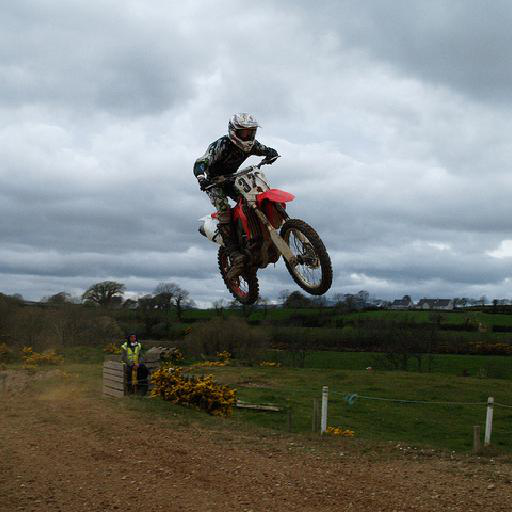

In [3]:
img_url ="https://marhamilresearch4.blob.core.windows.net/stego-public/sample_images/moto1.jpg"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
img

In [4]:
#load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
model.to(device)

Downloading:   0%|          | 0.00/4.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/937M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/241 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/120 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out

## Extract the visual embeddings and generate the DFF mask

In [5]:
pixel_values = feature_extractor(images=[img], return_tensors="pt").pixel_values
pixel_values = pixel_values.to(device)
pixel_values.shape

torch.Size([1, 3, 224, 224])

In [6]:
with torch.no_grad():
    last_hidden_state = model.encoder(pixel_values).last_hidden_state.squeeze(0).cpu()
last_hidden_state.shape

torch.Size([197, 768])

In [7]:
out = genenerate_vit_masks(last_hidden_state, img.size, k=10, return_heatmaps=True)
masks, heatmaps = out['masks'], out['heatmaps']

/opt/local/data/users/nl4xai/mcaf1/projects/vl_shap_repo/vl-shap/venv369/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/opt/local/data/users/nl4xai/mcaf1/projects/vl_shap_repo/vl-shap/venv369/lib/python3.6/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(<Figure size 432x288 with 12 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'3'}>],
        [<AxesSubplot:title={'center':'4'}>,
         <AxesSubplot:title={'center':'5'}>,
         <AxesSubplot:title={'center':'6'}>,
         <AxesSubplot:title={'center':'7'}>],
        [<AxesSubplot:title={'center':'8'}>,
         <AxesSubplot:title={'center':'9'}>,
         <AxesSubplot:title={'center':'10'}>, <AxesSubplot:>]],
       dtype=object))

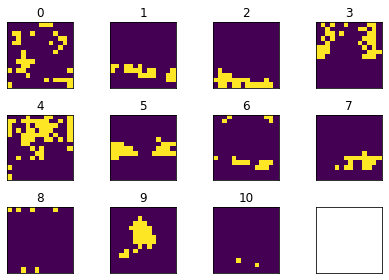

In [8]:
plot_masks(masks)

## Run the explainer

In [9]:
import torch.nn as nn

class ModelWrapper(nn.Module):
    def __init__(self, model, feature_extractor, tokenizer, device="cpu", max_length = 16, num_beams = 4):
        super().__init__()
        self.model = model
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.device = device
        self.gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

    def forward(self, img):
        # put here all to code to generate a caption from an image
        
        pixel_values = feature_extractor(images=[img], return_tensors="pt").pixel_values
        pixel_values = pixel_values.to(device)
        
        output_ids = model.generate(pixel_values, **self.gen_kwargs)
        gen = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]
        
        return gen

In [10]:
model_wrapper = ModelWrapper(model, feature_extractor, tokenizer, device=device)

In [11]:
model_wrapper(img)

'a person jumping a dirt bike in the air '

In [14]:
explainer = BaseExplainer(model_wrapper, device=device)

In [15]:
shap, base = explainer.explain(img, masks, k=-1)

100%|██████████| 2048/2048 [05:07<00:00,  6.65it/s]


Text(0.5, 1.0, 'Brute force KernelSHAP')

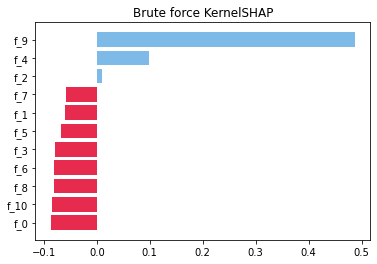

In [21]:
labels = [ f"f_{i}" for i in range(shap.shape[0]) ]
barh(labels, shap)

plt.title("Brute force KernelSHAP")

/opt/local/data/users/nl4xai/mcaf1/projects/vl_shap_repo/vl-shap/semshap/plot.py:60: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])
/opt/local/data/users/nl4xai/mcaf1/projects/vl_shap_repo/vl-shap/semshap/plot.py:61: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_yticks([], [])


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.colorbar.Colorbar at 0x7f4ae6145f28>)

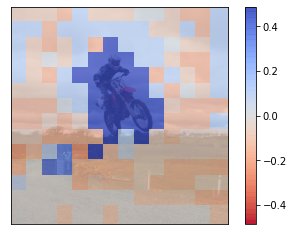

In [22]:
heatmap(img, masks, shap, alpha=0.75, vmin=-abs(max(shap)), vmax=abs(max(shap)))